In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

from torchsummary import summary

import pandas as pd
import numpy as np
from matplotlib import  pyplot as plt



In [14]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import pandas as pd
import numpy as np
device="cpu" if not torch.cuda.is_available() else "cuda:0"

In [15]:
DATA_PATH = "./data/eit/24x24_Images_11Cond_30k_2022-02-23.csv"

In [16]:
# Step 1: Define the custom dataset class
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_data = np.array(self.data.iloc[idx].values,dtype=np.float32)
        image = np.tanh(image_data.reshape(24, 24))  # Reshape to 24x24 and convert to PIL Image
        if self.transform:
            image = self.transform(image)

        return image

# Step 2: Define the transformation pipeline
transform = transforms.Compose([
    transforms.ToTensor(),
    # Add other transformations if needed
])

# Step 3: Create a DataLoader
batch_size = 64  # Adjust this according to your needs
dataset = CustomDataset(csv_file=DATA_PATH, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Step 4: Iterate through the DataLoader
dataiter = iter(dataloader)
for batch in dataiter:
    print(batch.shape)
    print(torch.min(batch),torch.max(batch))
    conv1 = nn.Conv2d(1, 16, 3, 2, 1) 
    conv2 = nn.Conv2d(16, 32, 3, 2, 1) 
    conv3 = nn.Conv2d(32, 64, 5) 
    dconv1 = nn.ConvTranspose2d(64, 32, 5)
    dconv2 = nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=0)
    print(conv1(batch).shape)
    print(conv2(conv1(batch)).shape)
    print(conv3(conv2(conv1(batch))).shape)
    print(dconv1(conv3(conv2(conv1(batch)))).shape)
    print(dconv2(dconv1(conv3(conv2(conv1(batch))))).shape)
    break

In [6]:
torch.manual_seed(123)
np.random.seed(123)

In [32]:
def e_out(i,k,s=1,p=0):
    o = int((i - k + 2*p) / s + 1)
    return o
def d_out(i,k,s=1,p=0,output_padding=0):
    o = int((i - 1) * s + k - 2*p) + output_padding
    return o

In [39]:
class AutoencoderEIT(nn.Module):
    def __init__(self):
        super().__init__()     
        # N, 1, 24, 24
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 12, 12
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # - > N, 32, 6, 6
            nn.ReLU(),
            nn.Conv2d(32, 64, 5), # -> N, 64, 2, 2
            nn.ReLU()
        )
        
        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 5), # -> N, 32, 6, 6
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 12, 12 (N,16,11,11 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 24, 24  (N,1,23,23)
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
 
# Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...
# Input [-1, +1] -> use nn.Tanh

In [40]:
model = AutoencoderEIT()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3,
                             weight_decay=1e-5)

In [94]:
model

AutoencoderEIT(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Tanh()
  )
)

In [ ]:
def psnr(reconstructed_image, ground_truth_image):
    # Calculate the Mean Squared Error (MSE)
    mse = F.mse_loss(reconstructed_image, ground_truth_image)
    print(mse)
    print(nn.MSELoss()(reconstructed_image, ground_truth_image))
    # Calculate the maximum possible pixel value (assuming pixel values are in the range [0, 1])
    max_pixel_value = 1.0
    
    # Calculate PSNR using the formula: PSNR = 20 * log10(max_pixel_value / sqrt(MSE))
    psnr = 20 * torch.log10(max_pixel_value / torch.sqrt(mse))
    
    return psnr.item()  # Convert the result to a Python float

# # Usage example
# reconstructed_image = torch.rand(1, 3, 256, 256)  # Replace with your reconstructed image tensor
# ground_truth_image = torch.rand(1, 3, 256, 256)   # Replace with your ground truth image tensor

# psnr_value = psnr(reconstructed_image, ground_truth_image)
# print(f"PSNR: {psnr_value:.2f} dB")

In [13]:
# Point to training loop video
num_epochs = 100
outputs = []
for epoch in range(num_epochs):
    for i, (img) in enumerate(dataloader):
        recon = model(img)
        loss = criterion(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.6f}')
    outputs.append((epoch, img, recon,loss.item()))


Epoch:1, Loss:0.000625
Epoch:2, Loss:0.000616
Epoch:3, Loss:0.000704
Epoch:4, Loss:0.000845
Epoch:5, Loss:0.000588
Epoch:6, Loss:0.000662
Epoch:7, Loss:0.000671
Epoch:8, Loss:0.000519
Epoch:9, Loss:0.000437
Epoch:10, Loss:0.000543
Epoch:11, Loss:0.000698
Epoch:12, Loss:0.000448
Epoch:13, Loss:0.000760
Epoch:14, Loss:0.000486
Epoch:15, Loss:0.000459
Epoch:16, Loss:0.000511
Epoch:17, Loss:0.000481
Epoch:18, Loss:0.000591
Epoch:19, Loss:0.000429
Epoch:20, Loss:0.000646
Epoch:21, Loss:0.000487
Epoch:22, Loss:0.000483
Epoch:23, Loss:0.000333
Epoch:24, Loss:0.000442
Epoch:25, Loss:0.000281
Epoch:26, Loss:0.000391
Epoch:27, Loss:0.000292
Epoch:28, Loss:0.000396
Epoch:29, Loss:0.000367
Epoch:30, Loss:0.000361
Epoch:31, Loss:0.000421
Epoch:32, Loss:0.000333
Epoch:33, Loss:0.000356
Epoch:34, Loss:0.000413
Epoch:35, Loss:0.000412
Epoch:36, Loss:0.000407
Epoch:37, Loss:0.000435
Epoch:38, Loss:0.000341
Epoch:39, Loss:0.000309
Epoch:40, Loss:0.000585
Epoch:41, Loss:0.000520
Epoch:42, Loss:0.000437
E

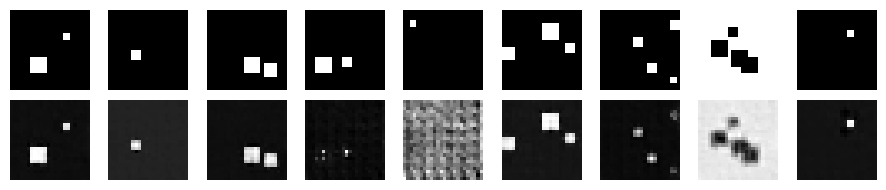

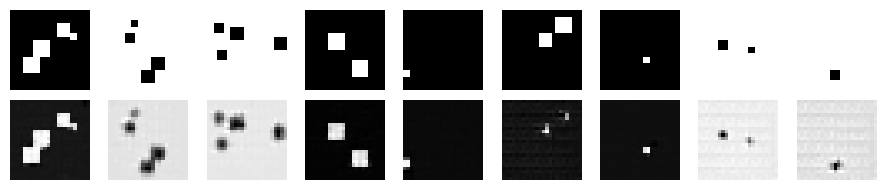

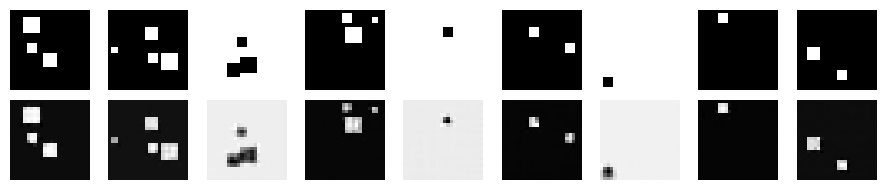

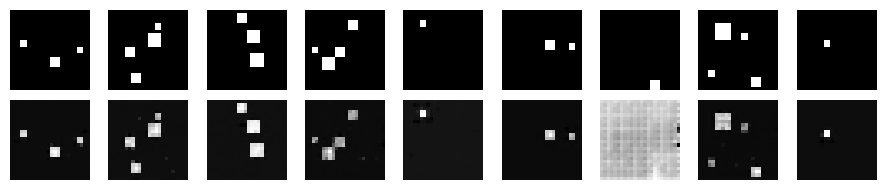

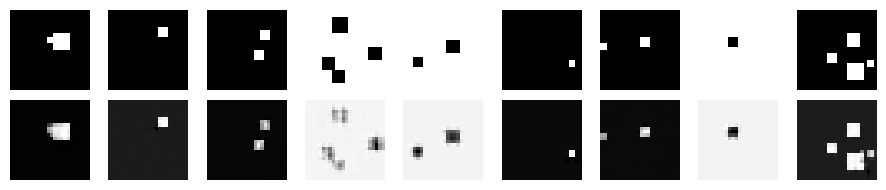

In [17]:
for k in range(0, num_epochs, 20):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.axis('off')
        # item: 1, 28, 28
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        plt.axis('off')
        plt.imshow(item[0])
    plt.tight_layout()
